# Autotalker Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 21.12.2022
- **Date of Last Modification:** 21.12.2022

## 1. Setup

### 1.1 Import Libraries

In [2]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

### 1.2 Define Parameters

In [21]:
## Dataset
dataset = "squidpy_seqfish_mouse_organogenesis"

## Model
# AnnData Keys
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
deeplinc_latent_key = "deeplinc_latent"

### 1.3 Run Notebook Setup

In [5]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [6]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [12]:
# Define paths
figure_path = f"../figures/{dataset}"
srt_data_folder_path = "../data/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
benchmark_data_folder_path = "../data/benchmark_data"

# Create required directories
os.makedirs(figure_path, exist_ok=True)

## 2. Data

### 2.1 Load Data & Compute Spatial Neighbor Graph

In [11]:
adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key="spatial",
                        radius=0.03875)

In [29]:
adata.obsm[deeplinc_latent_key] = np.load(f"{benchmark_data_folder_path}/deeplinc/run2/emb_hidden2_22.npy")

In [31]:
adata.obsm[deeplinc_latent_key]

array([[ 0.44840026,  0.4095279 ,  0.27254602, ...,  0.00249713,
         0.22971232,  0.43959036],
       [ 0.52195483,  0.36988732,  0.09020187, ..., -0.49185175,
         0.11005304, -0.41460598],
       [ 0.03786981,  0.07454717,  0.40682665, ..., -0.3426653 ,
         0.19174244,  0.24758312],
       ...,
       [ 0.59005463, -0.19957691, -0.06352405, ...,  0.6907055 ,
         0.46307772, -0.05412021],
       [ 1.3828728 , -0.6059761 , -0.46798608, ...,  0.6969166 ,
         0.0419609 , -1.2146573 ],
       [ 0.17522368, -0.37442207,  0.02373267, ...,  0.11247092,
         0.16365449,  0.6664656 ]], dtype=float32)

In [32]:
# Use deeplinc latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=deeplinc_latent_key)
sc.tl.umap(adata, min_dist=0.3)

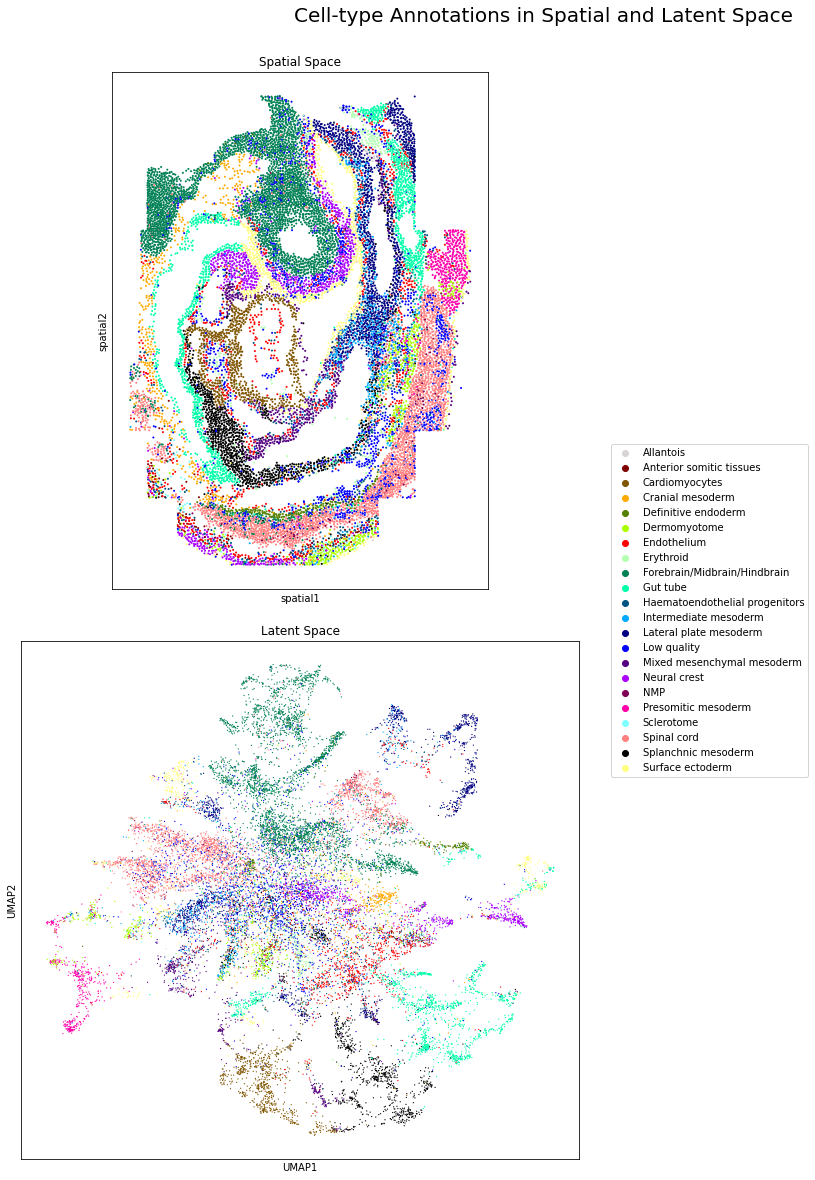

In [33]:
# Create subplot of cell-type annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Cell-type Annotations in Spatial and Latent Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.spatial(adata=adata,
              color=[cell_type_key],
              spot_size=0.03,
              title="Spatial Space",
              ax=axs[0],
              show=False)
sc.pl.umap(adata=adata,
           color=[cell_type_key],
           title="Latent Space",
           ax=axs[1],
           show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.225, 0.625))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
#fig.savefig(f"{figure_path}/cell_type_annotations_in_spatial_and_latent_space.png",
#            bbox_extra_artists=(lgd, title),
#            bbox_inches="tight")
plt.show()